### Analyzing the Correlation between Supershop Sales and Weather Patterns in Myanmar (Yangon, Mandalay, Naypyitaw): A Data-Driven Investigation

### Import Necessary Libraries


In [104]:
import logging, sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

### Load Data

In [105]:
try:
    connection = sqlite3.connect("../data/analysis.sqlite")
    weather = pd.read_sql_query(f"SELECT * FROM weather", connection)
    supermarket_sales = pd.read_sql_query(f"SELECT * FROM supermarket_sales ", connection)    
except sqlite3.Error as e:
    logging.error(msg=f"Error while creating SQLite DB: {e}")
    sys.exit(1)
finally:
    connection.close()

### Merge Data

In [106]:
supermarket_sales["Date"]= pd.to_datetime(supermarket_sales.Date)
weather["Date"]= pd.to_datetime(weather.Date)

yangon_sales = supermarket_sales[supermarket_sales['City']=="Yangon"]
mandalay_sales = supermarket_sales[supermarket_sales['City']=="Mandalay"]
naypyitaw_sales = supermarket_sales[supermarket_sales['City']=="Naypyitaw"]

yangon_weather = weather[weather['City']=="Yangon"]
mandalay_weather = weather[weather['City']=="Mandalay"]
naypyitaw_weather = weather[weather['City']=="Naypyitaw"]

yangon_combined_data = pd.merge(yangon_weather,yangon_sales,on= "Date")
mandalay_combined_data = pd.merge(mandalay_weather,mandalay_sales,on= "Date")
naypyitaw_combined_data = pd.merge(naypyitaw_weather,naypyitaw_sales,on= "Date")

### 1. Introduction

The retail industry, particularly supermarkets, is heavily influenced by external factors such as weather conditions. Understanding the relationship between weather patterns and Supershop sales is crucial for optimizing inventory management, pricing strategies, and marketing efforts. This project aims to explore the impact of temperature on Supershop sales in three major cities in Myanmar: Yangon, Mandalay, and Naypyitaw. The significance of understanding this correlation lies in its potential to revolutionize conventional strategies related to inventory management, pricing dynamics, and targeted marketing initiatives. By unraveling the interplay between weather nuances and purchasing trends, businesses can harness the power of predictive analytics to anticipate and respond to fluctuations in demand effectively. 

#### 1.1 Project Goals 
The following questions interest me whthin the scope of this project,

1. How does the temperature vary in Yangon, Mandalay and Naypyitaw cities during Jan to March in 2019?
2. How does the supermarket sales in those cities vary during the exact time frame?
3. Does temperature affect supermaket sales?

The subsequent sections of this report are structured as follows: Section 2 provides a comprehensive overview and analysis of the datasets. Following this, Section 3 elucidates the adopted methodology. Subsequently, Section 4 encompasses the presentation of the project's results. Finally, Section 5 comprises discussions, and remarks, and outlines avenues for future work in this project.

### 2. Data Sources:
To accomplish the project goals, two datasets were required. After a thorough investigation, I came across two sources online that meets the project requirements, namely Kaggle and Meteostat. I will briefly explain the datasets in below sections,


#### 2.1 Supermarket Sales Data:
This dataset provides daily sales information from Supershops in the specified cities, offering a comprehensive view of sales trends for Yangon, Mandalay, and Naypyitaw city. It is a very popular open-source dataset, I have collected it from Kaggle. The Table 1 contains the column names and descriptions of the supermaket sales dataset. 
         
* Metadata URL: https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales/data
* Data URL: https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales/download?datasetVersionNumber=3
* Data Type: CSV


<table>
    <tr>
        <th> Column index</th>
        <th> Column name </th>
        <th> Description </th>
    </tr>
    <tr>
        <td> 0 </td> 
        <td> Invoice id </td> 
        <td> Invoice identification number </td> 
    </tr>
    <tr>
        <td> 1 </td>
        <td> Branch </td>
        <td> Branch (3 branches available: A, B and C) </td> 
    </tr>
    <tr>
        <td> 2 </td>
        <td> City </td>
        <td> City name </td>
    </tr>
    <tr>
        <td> 3 </td>
        <td> Customer type </td>
        <td> Type of customers. </td> 
    </tr>
    <tr>
        <td> 4 </td> 
        <td> Gender </td>
        <td> Gender </td> 
    </tr>
    <tr>
        <td> 5 </td> 
        <td> Product line </td> 
        <td> General item categorization groups  </td> 
    </tr>
    <tr>
        <td> 6 </td> 
        <td> Unit price </td> 
        <td> Price of each product in $ </td> 
    </tr>
    <tr>
        <td> 7 </td> 
        <td> Quantity </td> 
        <td> Number of products purchased  </td> 
    </tr>
    <tr>
        <td> 8 </td> 
        <td> Tax </td>
        <td> 5% tax fee for customer buying  </td> 
    </tr>
    <tr>
        <td> 9 </td> 
        <td> Total </td>
        <td> Total price including tax </td>
    </tr>
    <tr>
        <td> 10 </td> 
        <td> Date </td> 
        <td> Date of purchase (Record available from January 2019 to March 2019)  </td> 
    </tr>
    <tr>
        <td> 11 </td> 
        <td> Time </td> 
        <td> Purchase time (10am to 9pm) </td> 
    </tr>
    <tr>
        <td> 12 </td> 
        <td> Payment </td> 
        <td> Payment type  </td> 
    </tr>
    <tr>
        <td> 13 </td> 
        <td> COGS </td> 
        <td> Cost of goods sold </td> 
    </tr>
    <tr>
        <td> 14 </td> 
        <td> Gross margin percentage </td> 
        <td> Gross margin percentage </td> 
    </tr>
    <tr>
        <td> 15 </td> 
        <td> Gross income </td>
        <td> Gross income </td> 
    </tr>
    <tr>
        <td> 16 </td> 
        <td> Rating </td> 
        <td> Customer stratification rating (On a scale of 1 to 10) </td> 
    </tr>
    <tr>
    <caption>Table 1: Daily super market sales dataset.</caption>
</table>


#### 2.2 Weather Data:
Weather data includes factors like temperature, humidity, wind speed, and precipitation. Obtained from Meteostat, this data aims to capture the meteorological conditions in Yangon, Mandalay, and Naypyitaw city. The Table 2 contains the column names and descriptions of the weather data.

* Metadata URL: https://dev.meteostat.net/bulk/daily.html
* Data URL: https://bulk.meteostat.net/v2/daily/station_id.csv.gz ; station_id = 48097, 48042, VYNT0
* Data Type: CSV


<table>
    <tr>
        <th> Column index</th>
        <th> Column name </th>
        <th> Description </th>
    </tr>
    <tr>
        <td> 0 </td> 
        <td> Date </td> 
        <td> The Date string (format: YYYY-MM-DD) </td> 
    </tr>
    <tr>
        <td> 1 </td>
        <td> Tavg </td>
        <td> The average air temperature in °C </td> 
    </tr>
    <tr>
        <td> 2 </td>
        <td> Tmin </td>
        <td> The minimum air temperature in °C </td>
    </tr>
    <tr>
        <td> 3 </td>
        <td> Tmax </td>
        <td> The maximum air temperature in °C </td> 
    </tr>
    <tr>
        <td> 4 </td> 
        <td> Prcp </td>
        <td> The daily precipitation total in mm </td> 
    </tr>
    <tr>
        <td> 5 </td> 
        <td> Snow </td> 
        <td> The maximum snow depth in mm </td> 
    </tr>
    <tr>
        <td> 6 </td> 
        <td> Wdir </td> 
        <td> The average wind direction in degrees (°) </td> 
    </tr>
    <tr>
        <td> 7 </td> 
        <td> Wspd </td> 
        <td> The average wind speed in km/h  </td> 
    </tr>
    <tr>
        <td> 8 </td> 
        <td> Wpgt </td>
        <td> The peak wind gust in km/h  </td> 
    </tr>
    <tr>
        <td> 9 </td> 
        <td> Pres </td>
        <td> The average sea-level air pressure in hPa </td>
    </tr>
    <tr>
        <td> 10 </td> 
        <td> Tsun </td> 
        <td> The daily sunshine total in minutes (m)  </td> 
    </tr>
    <caption>Table 2: Summery of Yagon, Mandalay, Naypyitaw dataset.</caption>
</table>



### 3. Methodology


<figure>
    <img src="images/Methodology.jpeg" style="width:80%">
    <figcaption align="center"> Figure 1: Methodology </figcaption>
</figure>

The following is a more detailed step-by-step description of the process:

Step 1: Run the ETL Pipelines and load the data into a SQLite database.

Step 2: Analyse the Naypyitaw, Mandaley, and Yagon city's weather and find how the temparature vary during Jan to March, 2019. 

Step 3: Analyse the Naypyitaw, Mandaley, and Yagon city's supershops sales and find out how the sales vary in those cities during the exact time frame.

Step 4: Run a Combined Analysis on Supershop sales and weather to find if there are any relationship between sales and temparature.

Step 5: Get the output. 

Figure 1 illustrates the project's methodology.



#### 3.1 Extract Transform Load (ETL) Pipeline:

The implementation of the ETL pipeline, depicted in Figure 2, played a pivotal role in this project. Raw data extraction from various sources marked the initial phase, followed by a series of cleaning processes detailed in Section 3.2. After transformation the refined data found its repository in a SQLite database for subsequent analysis. Notably, the utilization of a queue proved essential, particularly in consolidating weather data from multiple cities into a single table.

<figure>
    <img src="images/ETL_pipeline.jpeg" style="width:90%">
    <figcaption align="center"> Figure 2: ETL Pipeline structure </figcaption>
</figure>





#### 3.2 Data Cleaning/Transformation:

Both datasets underwent various transformations to enhance their relevance to the project. For the Supermarket sales dataset, non-essential columns "Invoice ID", "Branch", "Customer type", "Gender", "Unit price", "Tax 5%", "Time", "cogs", "gross margin percentage", "gross income", and "Rating"  were removed. 

As for the weather data, there were three city-specific datasets and I had to consolidated into one table. So, I have added a new column named "City". Subsequently, irrelevant columns "Prcp", "Snow", "Wdir", "Wspd", "Wpgt", "Pres", and "Tsun" were dropped. 

The final database comprises two tables: weather and supermarket_sales.



#### 3.3 Challenges Encountered:

Throughout the course of this project, I have encountered various challenges, with one particularly noteworthy obstacle involving the identification of appropriate datasets that aligned with the project's specific requirements. Navigating the online landscape, I discovered that not all datasets were open source or directly relevant to our project topic. Numerous revisions were necessary to go through available options and ultimately select datasets that met the criterias.

Additionally, I have faced the challenge of collecting weather data for three distinct cities and combined them into a cohesive dataset in real-time within our pipeline. To tackle this hurdle, I implemented a pipeline queue to meticulously execute the extraction, transformation, and loading processes for weather data in a sequential manner. This strategic approach allowed to address the complexities associated with combining data from multiple sources and ensured the seamless integration of weather information from the specified cities during the runtime of our project pipeline. 

Lastly, while merging the dataset on "Date" I found the date format was not same. Therefore, I had to make the date format identical for both datasets.



#### 3.4 Python pakage to run ETL pipeline 
Inspired by Jayvee, my coursemate Badiuzzaman Pranto, and I collaborated on the development of an open-source [Python package](https://github.com/prantoamt/etl-pipeline-runner) throughout our coursework. Our individual projects in this course had distinct objectives,resulting in the creation of ETL pipelines with varying structures.In my project, the challenge revolved around extracting data from a source providing direct CSV files, accompanied by unique set of transformations, and subsequently loading it into the database. On the other hand, Pranto’s project centered extracting data from Kaggle archives. Recognizing these are foundational requirements for any data science project, we deliberately structured our code in a generic manner, giving rise to the inception of this reusable Python package.


<figure>
    <img src="images/ETL_pipeline_directory.jpeg" style="width:60%">
    <figcaption align="center"> ETL Pipeline's Directory </figcaption>
</figure>

##### 3.4.1 Features as of version 1.1.0:

1. Data Extraction Capabilities:

- Extract data from Kaggle (Contributed by Pranto).

- Extract data directly from sources providing CSV files (Contributed by me).

- Handle CSV files seamlessly (Joint contribution).

2. Data Transformation and Loading:

- Perform project-specific transformations with flexibility (Joint contribution).

- Load data efficiently into SQLite databases (Joint contribution).

3. Pipeline Management:

- Run multiple pipelines in a queue for streamlined execution (Joint contribution).

##### 3.4.2 Possible features for future:

1. Expand Data Source Compatibility:

- Enhance data extraction capabilities by allowing archives to be extracted from sources other than Kaggle.

2. Database Interaction:

- Enable data extraction directly from databases, broadening the scope of data sources.

3. File Format Compatibility:

- Handle XL/XLS files to accommodate a wider range of data formats.

4. Database Flexibility:

- Extend data loading capabilities to support other types of databases.

5. Parallel execution:

- Execute multiple pipelines concurrently.

**You are warmly invited to submit feature requests, actively contribute to the package’s development, and collec-tively address the evolving needs of the data science community.**


## 4. Result: 





#### Temparature variation in cities from Jan to March 2019?

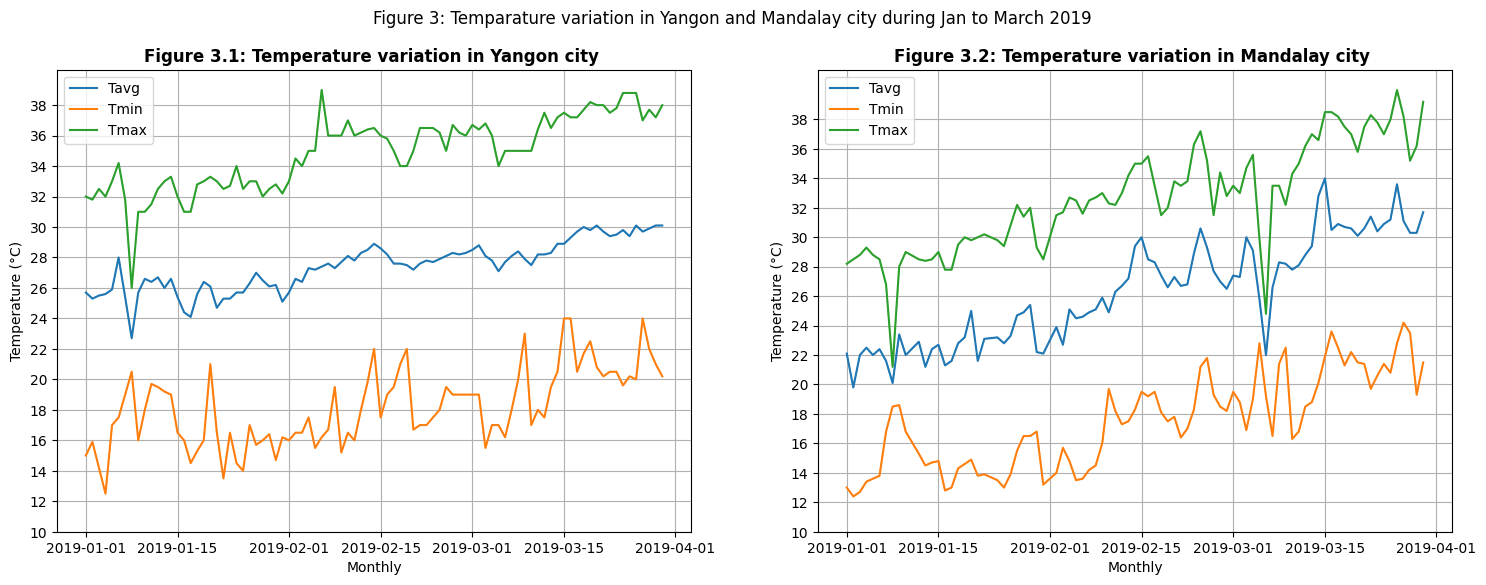

In [203]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
datas = [yangon_combined_data, mandalay_combined_data, naypyitaw_combined_data]
for col in ["Tavg", "Tmin", "Tmax"]:
    ax = axes[0]
    sns.lineplot(data = yangon_combined_data, x="Date", y=col, label= col, ax=ax)

    ax.set_yticks(np.arange(10,40,2))
    ax.set_xlabel("Monthly") 
    ax.set_ylabel("Temperature (°C)")
    ax.set_title("Figure 3.1: Temperature variation in Yangon city ", fontweight="bold")
    ax.grid(True) 
     
for col in ["Tavg", "Tmin", "Tmax"]:
    ax = axes[1]
    sns.lineplot(data = mandalay_combined_data, x="Date", y=col, label= col, ax=ax)

    ax.set_yticks(np.arange(10,40,2))
    ax.set_xlabel("Monthly") 
    ax.set_ylabel("Temperature (°C)")
    ax.set_title("Figure 3.2: Temperature variation in Mandalay city ", fontweight="bold")
    ax.grid(True)     

plt.suptitle ("Figure 3: Temparature variation in Yangon and Mandalay city during Jan to March 2019")
plt.show()
    

I have graphed the temperature variations for Yangon and Mandalay city. Unfortunately, no temperature data was available for Naypyitaw during this specific time frame.

#### Supershop Sells variation of Yangon, Mandalay and Naypyitaw cities Jan to march 2019:

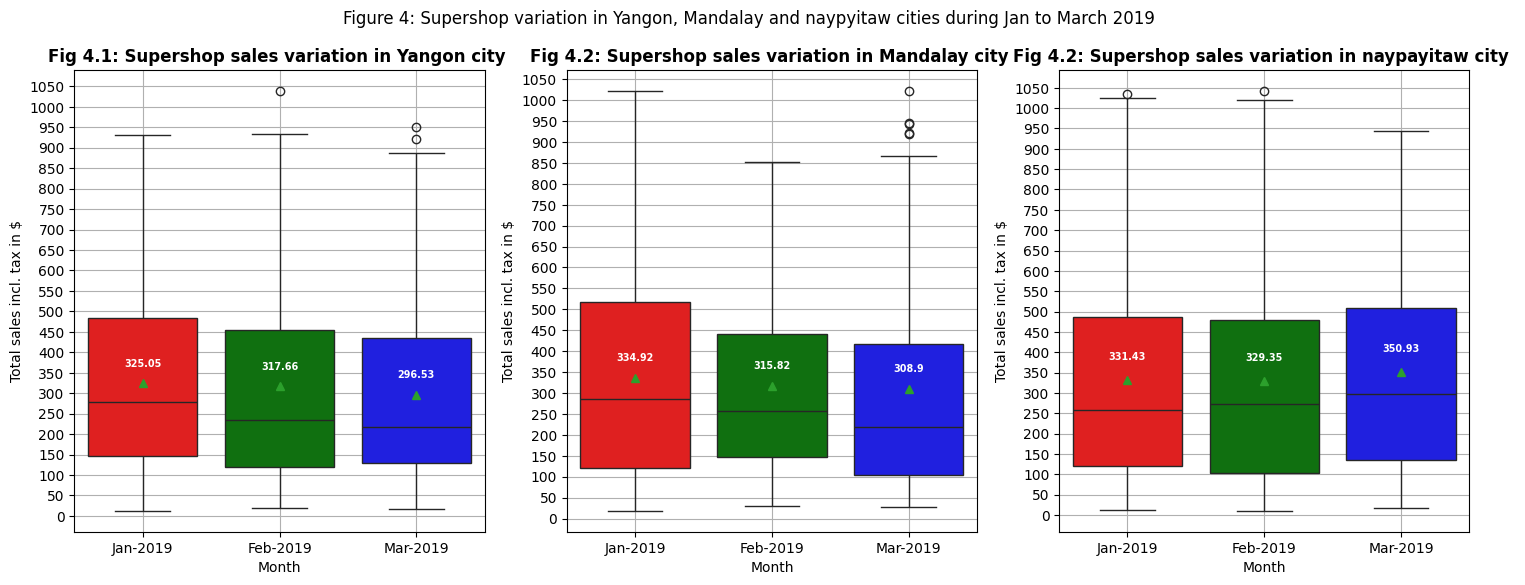

In [195]:
xtick_map = {0:"Jan-2019", 1:"Feb-2019", 2:"Mar-2019"}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
for col in ["Total"]:
    ax = axes[0]
    box_plot = sns.boxplot(data = yangon_combined_data, x="Month", y=col, ax=ax, showmeans= True, palette=["r","g","b"], hue= "Month")
    mean = np.round(yangon_combined_data.groupby(['Month'])['Total'].mean(), decimals= 2)
    vertical_offset = yangon_combined_data['Total'].mean() * 0.13 
    
    for xtick in box_plot.get_xticks(): 
            box_plot.text(xtick,mean[xtick_map[xtick]] + vertical_offset,mean[xtick_map[xtick]], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
     
    ax.set_yticks(np.arange(0,1100,50))
    ax.set_xlabel("Month") 
    ax.set_ylabel("Total sales incl. tax in $")
    ax.set_title("Fig 4.1: Supershop sales variation in Yangon city ", fontweight="bold")
    ax.grid(True) 
     
for col in ["Total"]:
    ax = axes[1]
    box_plot = sns.boxplot(data = mandalay_combined_data, x="Month", y=col, ax=ax, showmeans= True, palette=["r","g","b"], hue= "Month")
    mean = np.round(mandalay_combined_data.groupby(['Month'])['Total'].mean(), decimals= 2)
    vertical_offset = mandalay_combined_data['Total'].mean() * 0.13
    
    for xtick in box_plot.get_xticks():
            box_plot.text(xtick,mean[xtick_map[xtick]] + vertical_offset,mean[xtick_map[xtick]], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
     
    ax.set_yticks(np.arange(0,1100,50)) 
    ax.set_xlabel("Month") 
    ax.set_ylabel("Total sales incl. tax in $")
    ax.set_title("Fig 4.2: Supershop sales variation in Mandalay city ", fontweight="bold")
    ax.grid(True)     

for col in ["Total"]:
    ax = axes[2]
    box_plot = sns.boxplot(data = naypyitaw_sales.sort_values(by="Date"), x="Month", y=col, ax=ax, showmeans= True, palette=["r","g","b"], hue= "Month")
    mean = np.round(naypyitaw_sales.groupby(['Month'])['Total'].mean(), decimals= 2)
    vertical_offset = naypyitaw_sales['Total'].mean() * 0.15
    
    for xtick in box_plot.get_xticks():
            box_plot.text(xtick,mean[xtick_map[xtick]] + vertical_offset,mean[xtick_map[xtick]], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

    ax.set_yticks(np.arange(0,1100,50))
    ax.set_xlabel("Month") 
    ax.set_ylabel("Total sales incl. tax in $")
    ax.set_title("Fig 4.2: Supershop sales variation in naypayitaw city ", fontweight="bold")
    ax.grid(True)    


plt.suptitle ("Figure 4: Supershop variation in Yangon, Mandalay and naypyitaw cities during Jan to March 2019")
plt.show()
    

#### Realationship between temparature and supershop sells in those cities during the exact time frame: 


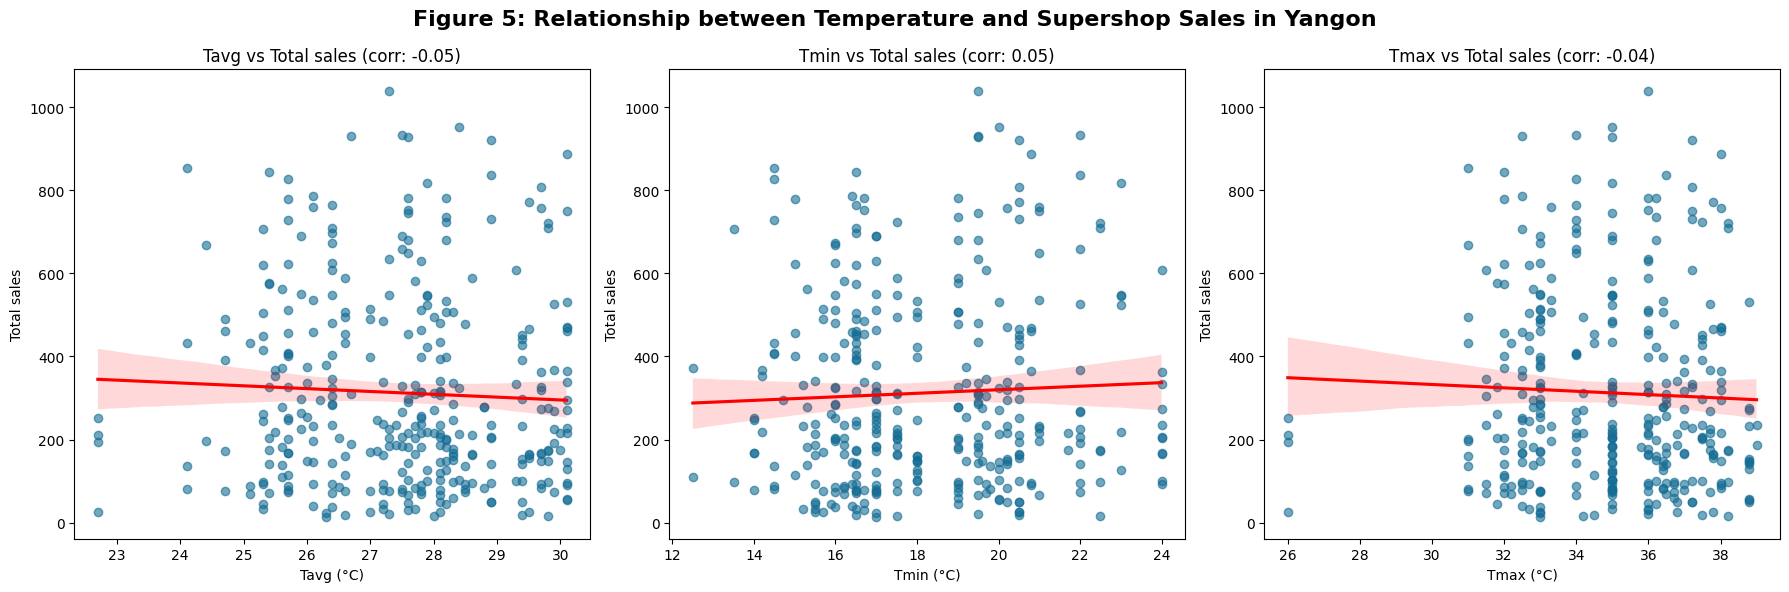

In [201]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, col in enumerate(['Tavg', 'Tmin', 'Tmax']):
    ax = axes[i]
    sns.regplot(data=yangon_combined_data, x=col, y='Total', ax=ax,
                scatter_kws = {"color": "#146C94", "alpha": 0.6},
                line_kws = {"color": "red"},
                ci = 95)
    
    
    correlation = yangon_combined_data[[col, 'Total']].corr().iloc[0, 1]
    
    ax.set_title(f'{col} vs Total sales (corr: {correlation:.2f})')
    ax.set_xlabel(col+' (°C)')
    ax.set_ylabel('Total sales')

plt.suptitle('Figure 5: Relationship between Temperature and Supershop Sales in Yangon', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

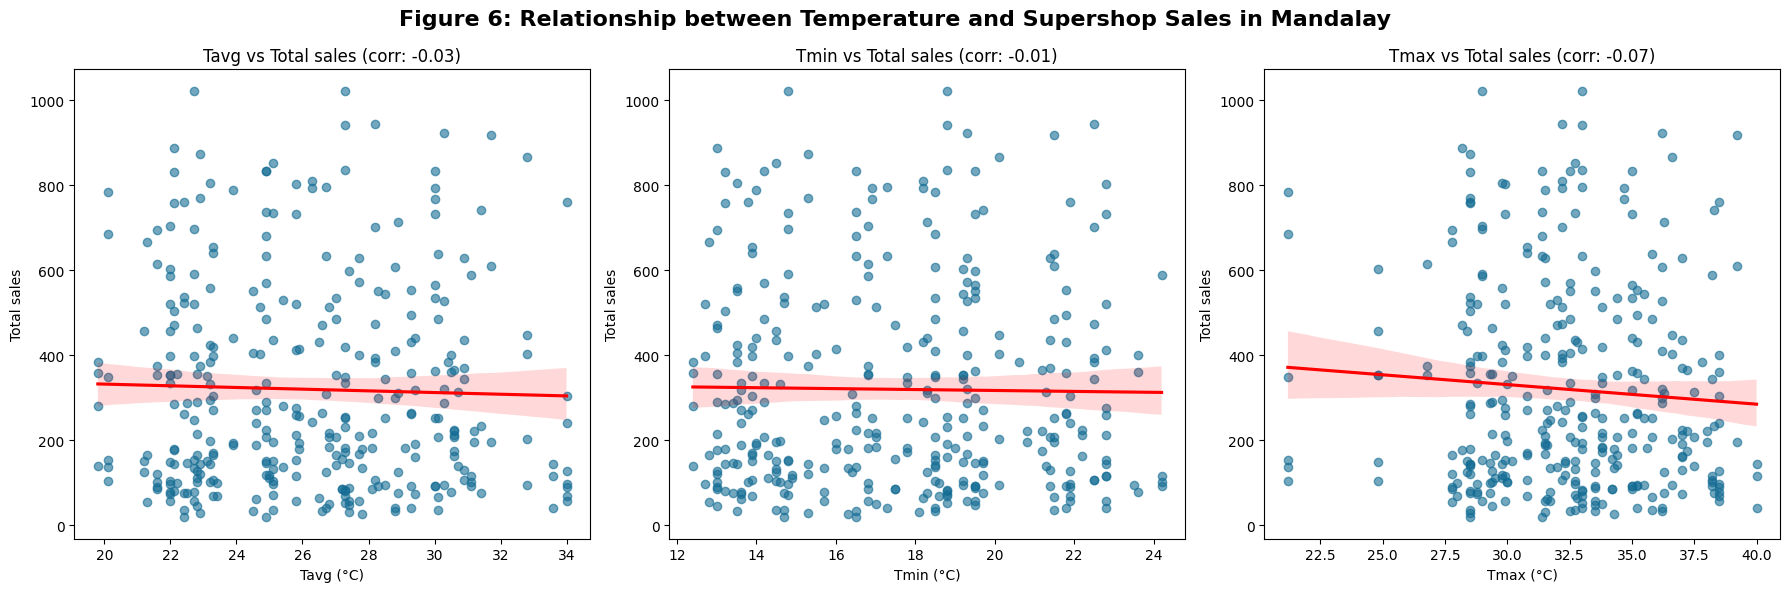

In [202]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, col in enumerate(['Tavg', 'Tmin', 'Tmax']):
    ax = axes[i]
    sns.regplot(data=mandalay_combined_data, x=col, y='Total', ax=ax,
                scatter_kws = {"color": "#146C94", "alpha": 0.6},
                line_kws = {"color": "red"},
                ci = 95)
    
    
    correlation = mandalay_combined_data[[col, 'Total']].corr().iloc[0, 1]
    
    ax.set_title(f'{col} vs Total sales (corr: {correlation:.2f})')
    ax.set_xlabel(col+' (°C)')
    ax.set_ylabel('Total sales')

plt.suptitle('Figure 6: Relationship between Temperature and Supershop Sales in Mandalay', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Discussion/Conclusions: 


### Interpretation of Results:

Upon analysis on section 4, I am prepared to delve into the outcomes of my project and address the objectives set forth in my project goals in below:

**How does the temperature in Yangon, Mandalay and Naypytiaw cities vary Jan to March in year 2019?**

The variation in temperature in Yangon city is evident from Figure 3.1. Analysis reveals that the temperature experiences significant fluctuations, with the lowest point in January, followed by a gradual increase in February and March. March records the highest temperature. In January, the lowest average temperature was recorded at 22.70°C, while the highest reached 28.00°C. Moving on to February, the lowest average temperature stood at 25.70°C, with the highest reaching 28.90°C. March registered a minimum average temperature of 27.10°C and a maximum of 30.10°C.

After analysis in 3.2, it becomes apparent that Mandalay city is cooler than Yangon city. Nonetheless, the temperature undergoes notable fluctuations, reaching its lowest point in January and gradually increasing in February and March. March marks the peak temperature.  During January, the recorded lowest average temperature was 19.80°C, accompanied by a peak of 25.40°C. Progressing into February, the minimum average temperature was 22.70°C, with the maximum average soaring to 30.60°C. As for March, the observed temperature range encompassed a minimum average of 22.00°C and a maximum of 34.00°C.

As I mentioned earlier,I've plotted the temperature fluctuations for both Yangon and Mandalay cities. Regrettably, there is no temperature data accessible for Naypyitaw during this particular time period.

**How does the supermarket sales in those cities vary during the exact time frame?**

Based on the analysis depicted in Figure 4, a noticeable trend emerges in Yangon, where supermarket sales exhibit variation from January to March. In January, the mean sales peak, followed by a slight decrease in February and March. March registers the lowest mean sales in this sequence. This observed pattern is mirrored in Mandalay as well. However, Naypyitaw city stands out, displaying the highest mean sales in March, followed by February and then January. Notably, January represents the month with the lowest mean sales for Naypyitaw city.

Furthermore, comparing the three major cities, Naypyitaw experiences the highest average sales in March, reaching (\$350.93) per day, while Yangon and mandalay records the lowest mean sales in March with \$296.53 and \$308.90 per day.

**Does temperature affect supermaket sales?**

Analyzing Figure 5, it becomes evident that there is an exiguous negative correlation between temperature and supermarket sales in Yangon city.  It can be inferred that higher temperatures are associated with comparatively lower supermarket sales in the area.
As for Mandalay city in Figure 6, we observe a slight negative correlation between temperature and supermarket sales as well. This suggests that when the temperature is high, supermarket sales tend to be relatively lower.

In summary , we can say, the temparature does effect the supermarket sales in Yangon and Mandalay cities but not significantlly.
Unfortunately, this relationship could not be explored for Naypyitaw city due to the absence of temperature data during this specific time frame.

### Limitations/Future Scope:

Despite the thorough data engineering process, certain limitations are present. The absence of available temperature data for Naypyitaw city prevent the exploration of the relationship between temperature and sales for this specific location.

Acquiring temperature data for this city would be intriguing, allowing for a more in-depth examination of its correlation with sales in future.
